In [ ]:
import os
os.environ["WANDB_API_KEY"] = "00c5bcfd2b2fbe9bce38152923c98635448f8c6f"

In [ ]:
os.system('mkdir ../dataset') 
os.system('mkdir ../models')
os.system('wget -O ../dataset/KDDTrain+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B.txt')
os.system('wget -O ../dataset/KDDTest+.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest%2B.txt')
os.system('wget -O ../dataset/KDDTrain+_20Percent.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTrain%2B_20Percent.txt')
os.system('wget -O ../dataset/KDDTest-21.txt https://raw.githubusercontent.com/acen20/DEL/master/deep-ensemble-jet/dataset/KDDTest-21.txt')
os.system('wget -O ../models/r2l_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/r2l_gen.pt')
os.system('wget -O ../models/u2r_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/u2r_gen.pt')
os.system('wget -O ../models/dos_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/dos_gen.pt')
os.system('wget -O ../models/probe_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/probe_gen.pt')
os.system('wget -O ../models/normal_gen.pt https://github.com/acen20/DEL/raw/master/IDSGAN/normal_gen.pt')

0

In [ ]:
os.system('pip install wandb -q')
os.system(f'wandb login {os.environ["WANDB_API_KEY"]}')
import wandb

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
#plt.style.use('grayscale')
from sklearn.metrics import precision_recall_curve,RocCurveDisplay
from matplotlib import pyplot
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold as KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing
import time

In [ ]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(f'Using {device} as device')

Using cpu as device


In [ ]:
class Critic(nn.Module):
  def __init__(self, data_dim):
    super(Critic,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(111, data_dim),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, data_dim):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.Conv1d(1,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Conv1d(3,3,kernel_size=3,stride=1),
        #nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Linear(96, data_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.gen(x)

In [ ]:
def visualize_synthetic_data(generated, original, title):
  generated = generated[np.random.randint(0,len(generated),41)]
  original = original.iloc[np.random.randint(0,len(original),41),:41][:41]

  fig, (original_ax, synthesized_ax) = plt.subplots(1,2,figsize=(12,12))
  original_ax.set_title(f'Original({title})')
  synthesized_ax.set_title(f'Synthetic({title})')
  _ = original_ax.imshow(original)
  _ = synthesized_ax.imshow(generated)

In [ ]:
def generate_data(generator, num_instances, z_dim):
  generator.eval()
  with torch.no_grad():
    out = generator(torch.randn(num_instances, z_dim).view(-1,1,z_dim))
    return out.detach().reshape(-1,41)[:num_instances]

In [ ]:
def create_dataloader(X, y, batch_size):
  if y:
    y = np.array(X['41'])
  else:
    y = torch.ones(size=(X.shape[0],))
  y = torch.tensor(y, dtype=torch.float).to(device)

  X = np.array(X.iloc[:,:-1])
  X = torch.tensor(X, dtype=torch.float).to(device)

  pt_train = TensorDataset(X,y)
  pt_train = DataLoader(pt_train, batch_size=batch_size)
  return pt_train

In [ ]:
def normalize_data(X):
  mms = MinMaxScaler()
  return mms.fit_transform(X)

In [ ]:
def visualize_train_loss(loss_1, labels, epochs, loss_2 = None):
  plt.figure(figsize=(10,4))
  plt.plot(loss_1, linewidth=2)
  if loss_2:
    plt.plot(loss_2, linewidth=2)
  plt.legend(labels)
  plt.ylabel("loss")
  _ = plt.xlabel(f"epochs ({epochs})")

## Preprocessing

In [ ]:
df=pd.read_csv('../dataset/KDDTrain+.txt', header=None)
df2=pd.read_csv('../dataset/KDDTest+.txt', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.columns = [str(i) for i in range(0, len(df.columns))]
df2.columns = [str(i) for i in range(0, len(df2.columns))]

In [ ]:
# Replacing Null values with 0. ML classifer cannot learn on Null values
df.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

In [ ]:
# Peak on dataset
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df.shape

(125973, 43)

In [ ]:
# Peak on the dataset
df.drop('42',axis=1, inplace=True)
df2.drop('42',axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
sub_classes = df.iloc[:,41].value_counts()

In [ ]:
print(sub_classes)

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: 41, dtype: int64


In [ ]:
r2l = ['ftp_write','guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient','warezmaster','xlock', 'xsnoop','named',
       'sendmail','snmpgetattack', 'snmpguess','httptunnel']
u2r = ['buffer_overflow', 'loadmodule','perl','ps','rootkit','sqlattack','xterm']
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop','pod','mailbomb', 'processtable','udpstorm', 'worm','apache2']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan','saint','mscan']
normal = ['normal']

In [ ]:
pd.set_option('display.max_rows', None) # or 1000.
train_1 = df['1'].value_counts()
train_1.rename('Train', inplace=True)
test_1 = df2['1'].value_counts()
test_1.rename('Test', inplace=True)
cnct = pd.concat([train_1, test_1], axis = 1)
cnct

,Train,Test
tcp,102689,18880
udp,14993,2621
icmp,8291,1043


In [ ]:
train_2 = df['2'].value_counts()
train_2.rename('Train', inplace=True)
test_2 = df2['2'].value_counts()
test_2.rename('Test', inplace=True)
cnct = pd.concat([train_2, test_2], axis = 1)
cnct

,Train,Test
http,40338,7853.0
private,21853,4774.0
domain_u,9043,894.0
smtp,7313,934.0
ftp_data,6860,851.0
eco_i,4586,262.0
other,4359,838.0
ecr_i,3077,752.0
telnet,2353,1626.0
finger,1767,136.0


In [ ]:
train_3 = df['3'].value_counts()
train_3.rename('Train', inplace=True)
test_3 = df2['3'].value_counts()
test_3.rename('Test', inplace=True)
cnct = pd.concat([train_3, test_3], axis = 1)
cnct

,Train,Test
SF,74945,14875
S0,34851,2013
REJ,11233,3850
RSTR,2421,669
RSTO,1562,773
S1,365,21
SH,271,73
S2,127,15
RSTOS0,103,2
S3,49,249


In [ ]:
df_X = df.drop('41', axis=1)
le = LabelEncoder()
for i in df_X:
  if df_X[i].dtype=='object':
    le.fit(df_X[i])
    df_X[i] = le.transform(df_X[i])
    df2[i] = le.transform(df2[i])
df.iloc[:,:40] = df_X

In [ ]:
df.iloc[:,:40] = normalize_data(df.iloc[:,:40])
df2.iloc[:,:40] = normalize_data(df2.iloc[:,:40])

In [ ]:
u2r_attacks = df[df['41'].apply(lambda x: x in u2r)].copy()
r2l_attacks = df[df['41'].apply(lambda x: x in r2l)].copy()
dos_attacks = df[df['41'].apply(lambda x: x in dos)].copy()
probe_attacks = df[df['41'].apply(lambda x: x in probe)].copy()
normal_traffic = df[df['41'].apply(lambda x: x in normal)].copy()

df['41'] = df['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

df2['41'] = df2['41'].map(
    lambda x: 'malicious' if x in r2l 
    else 'malicious' if x in u2r 
    else 'malicious' if x in dos 
    else 'malicious' if x in probe 
    else 'normal' if x is 'normal'
    else x
    )

### Training set value counts

In [ ]:
df['41'].value_counts()

normal       67343
malicious    58630
Name: 41, dtype: int64

### Testing set value counts

In [ ]:
print(df2['41'].value_counts())

malicious    12833
normal        9711
Name: 41, dtype: int64


In [ ]:
#In case of multi-class classification
#df_Y = le.fit(df['41']).transform(df['41'])
#df.iloc[:,41] = df_Y
#df_Y = le.transform(df2['41'])
#df2.iloc[:,41] = df_Y

#In case of binary classification
df.iloc[:,41] = df['41'].map(lambda x: 0 if x=='normal' else 1)
df2.iloc[:,41] = df2['41'].map(lambda x: 0 if x=='normal' else 1)

X_train = df.drop(['41'],axis=1)
y_train = df['41']

X_test = df2.drop(['41'],axis=1)
y_test = df2['41']
X_test = torch.tensor(np.array(X_test), dtype=torch.float, device=device)

**Creating TensorDataset**

In [ ]:
pt_x_train = torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)
y = nn.functional.one_hot(torch.tensor(y_train.to_numpy()))
pt_y_train = y.float().to(device)
tensor_dataset = TensorDataset(pt_x_train, pt_y_train)

In [ ]:
pt_x_train.shape, pt_y_train.shape

(torch.Size([125973, 41]), torch.Size([125973, 2]))

## **MLP**



In [ ]:
class MLP(nn.Module):
  data_dim = 41
  def __init__(self):
      super(MLP, self).__init__()
      self.mlp = nn.Sequential(
          nn.Linear(self.data_dim, 80),
          nn.ReLU(),
          nn.BatchNorm1d(80)
      )
      '''self.cnn = nn.Sequential(
          nn.Conv1d(1,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Conv1d(10,10,kernel_size = (1,3), stride=1),
          nn.ReLU(),
          nn.BatchNorm2d(10),
          nn.Flatten(),
          nn.Linear(330, 24),
          nn.ReLU(),
      )'''

      self.clf = nn.Sequential(
          nn.Linear(80,2),
          nn.Sigmoid()
      )

  def forward(self, x):
      features = self.mlp(x)
      return self.clf(features)

  def transform(self, x):
      return self.cnn(x)

In [ ]:
def validation_accuracy(model, X, y):
  model.eval()
  with torch.no_grad():
    lr_probs = model(X).detach().squeeze()
  preds = torch.argmax(lr_probs, dim=1).cpu()
  acc = accuracy_score(y, preds)
  model.train()
  return acc

In [ ]:
batch_sizes = [32, 64, 128, 256]
epochs_ = [25, 40, 55, 70]
learning_rates = [1e-3, 1e-2, 1e-1]

In [ ]:
start_time = time.time()

In [ ]:
grid_scores = []
iters = 0
#Creating a Grid Search
for epochs in epochs_:
  for lr in learning_rates:
    for batch_size in batch_sizes:
      #Model init
      pt_train = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
      mlp = MLP().to(device)
      criterion = nn.BCELoss()
      optimizer = torch.optim.SGD(mlp.parameters(), lr = lr)
      
      #Training Loop
      run = wandb.init(entity='ahsen', project='nids', name=f'MLP_{iters}', reinit=True)
      wandb.config["lr"] = lr
      wandb.config["batch_size"] = batch_size
      wandb.config["epochs"] = epochs
      print('===============================================')
      print(f"Batch Size:{batch_size}\tEpochs:{epochs}\tLR:{lr}")
      num_epochs = epochs
      outputs = []
      losses = []
      for epoch in range(num_epochs):
          for instance, y in pt_train:
              output = mlp(instance)
              loss = criterion(output, y)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          losses.append(loss.item())
          acc = validation_accuracy(mlp, X_test, y_test)
          wandb.log({'loss':loss.item()})
          print('------------------------------------------------')
          print(f'Epoch:{epoch+1}  \tLoss:{loss.item():.4f}\t Acc: {acc:.4f}')

      print("*************************************************")
      print(f'Final Score for (B:{batch_size}, Ep:{epochs}, LR:{lr})')
      print(f'Acc: {acc:.4f}')
      #Save scores
      obj = {
        "config":{
          "learning_rate": lr,
          "epochs": epochs,
          "batch_size": batch_size,
          "acc": acc,
          },
        "weights": mlp.state_dict()
      }
      wandb.log({"acc" : acc})
      run.finish()
      grid_scores.append(obj)
      iters = iters + 1

Batch Size:32	Epochs:30	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1898	 Acc: 0.7790
------------------------------------------------
Epoch:2  	Loss:0.1543	 Acc: 0.7890
------------------------------------------------
Epoch:3  	Loss:0.0977	 Acc: 0.7779
------------------------------------------------
Epoch:4  	Loss:0.0746	 Acc: 0.7835
------------------------------------------------
Epoch:5  	Loss:0.0658	 Acc: 0.7873
------------------------------------------------
Epoch:6  	Loss:0.0353	 Acc: 0.7886
------------------------------------------------
Epoch:7  	Loss:0.0336	 Acc: 0.7715
------------------------------------------------
Epoch:8  	Loss:0.0337	 Acc: 0.7810
------------------------------------------------
Epoch:9  	Loss:0.0515	 Acc: 0.7782
------------------------------------------------
Epoch:10  	Loss:0.0416	 Acc: 0.7838
------------------------------------------------
Epoch:11  	Loss:0.0246	 Acc: 0.7838
-----------------------------------------

loss,█▇▄▃▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▂▂▁▁
loss,0.01582


Batch Size:64	Epochs:30	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1386	 Acc: 0.7689
------------------------------------------------
Epoch:2  	Loss:0.0967	 Acc: 0.7585
------------------------------------------------
Epoch:3  	Loss:0.0779	 Acc: 0.7684
------------------------------------------------
Epoch:4  	Loss:0.0540	 Acc: 0.7694
------------------------------------------------
Epoch:5  	Loss:0.0474	 Acc: 0.7770
------------------------------------------------
Epoch:6  	Loss:0.0414	 Acc: 0.7773
------------------------------------------------
Epoch:7  	Loss:0.0387	 Acc: 0.7781
------------------------------------------------
Epoch:8  	Loss:0.0456	 Acc: 0.7630
------------------------------------------------
Epoch:9  	Loss:0.0422	 Acc: 0.7710
------------------------------------------------
Epoch:10  	Loss:0.0437	 Acc: 0.7702
------------------------------------------------
Epoch:11  	Loss:0.0391	 Acc: 0.7639
-----------------------------------------

loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▃▁▂▁
loss,0.02819


Batch Size:128	Epochs:30	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.2070	 Acc: 0.7547
------------------------------------------------
Epoch:2  	Loss:0.1695	 Acc: 0.7558
------------------------------------------------
Epoch:3  	Loss:0.1432	 Acc: 0.7597
------------------------------------------------
Epoch:4  	Loss:0.1340	 Acc: 0.7634
------------------------------------------------
Epoch:5  	Loss:0.1319	 Acc: 0.7676
------------------------------------------------
Epoch:6  	Loss:0.1146	 Acc: 0.7711
------------------------------------------------
Epoch:7  	Loss:0.1078	 Acc: 0.7810
------------------------------------------------
Epoch:8  	Loss:0.1022	 Acc: 0.7888
------------------------------------------------
Epoch:9  	Loss:0.0955	 Acc: 0.7891
------------------------------------------------
Epoch:10  	Loss:0.0887	 Acc: 0.7882
------------------------------------------------
Epoch:11  	Loss:0.0848	 Acc: 0.7892
----------------------------------------

loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.03858


Batch Size:256	Epochs:30	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1979	 Acc: 0.7830
------------------------------------------------
Epoch:2  	Loss:0.1692	 Acc: 0.7825
------------------------------------------------
Epoch:3  	Loss:0.1551	 Acc: 0.7867
------------------------------------------------
Epoch:4  	Loss:0.1474	 Acc: 0.7903
------------------------------------------------
Epoch:5  	Loss:0.1472	 Acc: 0.7901
------------------------------------------------
Epoch:6  	Loss:0.1492	 Acc: 0.7909
------------------------------------------------
Epoch:7  	Loss:0.1546	 Acc: 0.7903
------------------------------------------------
Epoch:8  	Loss:0.1573	 Acc: 0.7897
------------------------------------------------
Epoch:9  	Loss:0.1551	 Acc: 0.7847
------------------------------------------------
Epoch:10  	Loss:0.1439	 Acc: 0.7769
------------------------------------------------
Epoch:11  	Loss:0.1420	 Acc: 0.7735
----------------------------------------

loss,█▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁
loss,0.0844


Batch Size:32	Epochs:30	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1088	 Acc: 0.7782
------------------------------------------------
Epoch:2  	Loss:0.0521	 Acc: 0.7897
------------------------------------------------
Epoch:3  	Loss:0.0412	 Acc: 0.7883
------------------------------------------------
Epoch:4  	Loss:0.0361	 Acc: 0.7878
------------------------------------------------
Epoch:5  	Loss:0.0284	 Acc: 0.7832
------------------------------------------------
Epoch:6  	Loss:0.0344	 Acc: 0.7589
------------------------------------------------
Epoch:7  	Loss:0.0363	 Acc: 0.7761
------------------------------------------------
Epoch:8  	Loss:0.0360	 Acc: 0.7746
------------------------------------------------
Epoch:9  	Loss:0.0221	 Acc: 0.7652
------------------------------------------------
Epoch:10  	Loss:0.0608	 Acc: 0.7901
------------------------------------------------
Epoch:11  	Loss:0.0445	 Acc: 0.7886
------------------------------------------

loss,█▄▃▂▂▂▃▂▁▄▃▂▃▃▂▂▄▂▄▃▂▂▁▂▁▁▁▁▁▁
loss,0.01766


Batch Size:64	Epochs:30	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1342	 Acc: 0.7846
------------------------------------------------
Epoch:2  	Loss:0.1270	 Acc: 0.7701
------------------------------------------------
Epoch:3  	Loss:0.0939	 Acc: 0.7694
------------------------------------------------
Epoch:4  	Loss:0.0874	 Acc: 0.7773
------------------------------------------------
Epoch:5  	Loss:0.0785	 Acc: 0.7911
------------------------------------------------
Epoch:6  	Loss:0.0668	 Acc: 0.7885
------------------------------------------------
Epoch:7  	Loss:0.0456	 Acc: 0.7904
------------------------------------------------
Epoch:8  	Loss:0.0373	 Acc: 0.7906
------------------------------------------------
Epoch:9  	Loss:0.0369	 Acc: 0.7899
------------------------------------------------
Epoch:10  	Loss:0.0539	 Acc: 0.7948
------------------------------------------------
Epoch:11  	Loss:0.0485	 Acc: 0.7939
------------------------------------------

loss,██▅▅▄▄▂▂▂▃▃▂▂▂▃▁▂▂▁▃▂▅▃▁▁▂▂▁▂▁
loss,0.02962


Batch Size:128	Epochs:30	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1720	 Acc: 0.7799
------------------------------------------------
Epoch:2  	Loss:0.1336	 Acc: 0.7836
------------------------------------------------
Epoch:3  	Loss:0.1149	 Acc: 0.8116
------------------------------------------------
Epoch:4  	Loss:0.1211	 Acc: 0.8186
------------------------------------------------
Epoch:5  	Loss:0.1031	 Acc: 0.8130
------------------------------------------------
Epoch:6  	Loss:0.0806	 Acc: 0.8026
------------------------------------------------
Epoch:7  	Loss:0.0639	 Acc: 0.8070
------------------------------------------------
Epoch:8  	Loss:0.0497	 Acc: 0.8061
------------------------------------------------
Epoch:9  	Loss:0.0635	 Acc: 0.7993
------------------------------------------------
Epoch:10  	Loss:0.0487	 Acc: 0.8029
------------------------------------------------
Epoch:11  	Loss:0.0376	 Acc: 0.8006
-----------------------------------------

loss,█▆▅▆▅▄▃▂▃▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss,0.02403


Batch Size:256	Epochs:30	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1591	 Acc: 0.7893
------------------------------------------------
Epoch:2  	Loss:0.1510	 Acc: 0.7865
------------------------------------------------
Epoch:3  	Loss:0.1405	 Acc: 0.7866
------------------------------------------------
Epoch:4  	Loss:0.1308	 Acc: 0.7771
------------------------------------------------
Epoch:5  	Loss:0.1240	 Acc: 0.7754
------------------------------------------------
Epoch:6  	Loss:0.1235	 Acc: 0.7857
------------------------------------------------
Epoch:7  	Loss:0.1212	 Acc: 0.7754
------------------------------------------------
Epoch:8  	Loss:0.1120	 Acc: 0.7766
------------------------------------------------
Epoch:9  	Loss:0.1048	 Acc: 0.7807
------------------------------------------------
Epoch:10  	Loss:0.0989	 Acc: 0.7944
------------------------------------------------
Epoch:11  	Loss:0.0930	 Acc: 0.7929
-----------------------------------------

loss,██▇▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁
loss,0.03674


Batch Size:32	Epochs:30	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0992	 Acc: 0.7610
------------------------------------------------
Epoch:2  	Loss:0.0229	 Acc: 0.7908
------------------------------------------------
Epoch:3  	Loss:0.0686	 Acc: 0.7835
------------------------------------------------
Epoch:4  	Loss:0.0466	 Acc: 0.7818
------------------------------------------------
Epoch:5  	Loss:0.0424	 Acc: 0.7865
------------------------------------------------
Epoch:6  	Loss:0.0396	 Acc: 0.7849
------------------------------------------------
Epoch:7  	Loss:0.0340	 Acc: 0.7833
------------------------------------------------
Epoch:8  	Loss:0.0330	 Acc: 0.7799
------------------------------------------------
Epoch:9  	Loss:0.0280	 Acc: 0.7799
------------------------------------------------
Epoch:10  	Loss:0.0212	 Acc: 0.7737
------------------------------------------------
Epoch:11  	Loss:0.0229	 Acc: 0.7686
-------------------------------------------

loss,█▂▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss,0.01337


Batch Size:64	Epochs:30	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0490	 Acc: 0.7981
------------------------------------------------
Epoch:2  	Loss:0.0832	 Acc: 0.7977
------------------------------------------------
Epoch:3  	Loss:0.0454	 Acc: 0.7889
------------------------------------------------
Epoch:4  	Loss:0.0323	 Acc: 0.7919
------------------------------------------------
Epoch:5  	Loss:0.0242	 Acc: 0.7862
------------------------------------------------
Epoch:6  	Loss:0.0322	 Acc: 0.7828
------------------------------------------------
Epoch:7  	Loss:0.0489	 Acc: 0.7657
------------------------------------------------
Epoch:8  	Loss:0.0331	 Acc: 0.7662
------------------------------------------------
Epoch:9  	Loss:0.0287	 Acc: 0.7785
------------------------------------------------
Epoch:10  	Loss:0.0338	 Acc: 0.7207
------------------------------------------------
Epoch:11  	Loss:0.0175	 Acc: 0.7819
-------------------------------------------

loss,▅█▄▃▂▃▅▃▂▃▁▄▁▂▃▂▁▂▁▂▄▃▃▃▂▂▂▂▂▂
loss,0.01961


Batch Size:128	Epochs:30	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0731	 Acc: 0.7765
------------------------------------------------
Epoch:2  	Loss:0.0688	 Acc: 0.7773
------------------------------------------------
Epoch:3  	Loss:0.0812	 Acc: 0.7899
------------------------------------------------
Epoch:4  	Loss:0.1418	 Acc: 0.7456
------------------------------------------------
Epoch:5  	Loss:0.0745	 Acc: 0.7245
------------------------------------------------
Epoch:6  	Loss:0.0825	 Acc: 0.7263
------------------------------------------------
Epoch:7  	Loss:0.0587	 Acc: 0.7639
------------------------------------------------
Epoch:8  	Loss:0.1148	 Acc: 0.7488
------------------------------------------------
Epoch:9  	Loss:0.1144	 Acc: 0.7813
------------------------------------------------
Epoch:10  	Loss:0.1258	 Acc: 0.7386
------------------------------------------------
Epoch:11  	Loss:0.0365	 Acc: 0.7880
------------------------------------------

loss,▃▃▄█▃▄▂▆▆▇▁▂▂▂▃▂█▃▆▃▄▃▆▆▅▄▇▂▂▂
loss,0.05673


Batch Size:256	Epochs:30	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0905	 Acc: 0.7931
------------------------------------------------
Epoch:2  	Loss:0.1184	 Acc: 0.7619
------------------------------------------------
Epoch:3  	Loss:0.0819	 Acc: 0.7892
------------------------------------------------
Epoch:4  	Loss:0.0388	 Acc: 0.7642
------------------------------------------------
Epoch:5  	Loss:0.0422	 Acc: 0.7745
------------------------------------------------
Epoch:6  	Loss:0.0474	 Acc: 0.7682
------------------------------------------------
Epoch:7  	Loss:0.0524	 Acc: 0.7760
------------------------------------------------
Epoch:8  	Loss:0.0871	 Acc: 0.7699
------------------------------------------------
Epoch:9  	Loss:0.0793	 Acc: 0.7881
------------------------------------------------
Epoch:10  	Loss:0.0540	 Acc: 0.7941
------------------------------------------------
Epoch:11  	Loss:0.0411	 Acc: 0.7781
------------------------------------------

loss,▆█▅▂▂▃▃▆▅▃▂▃▅▃▂▂▃▂▁▂▁▁▁▆▂█▂▃▂▄
loss,0.0602


Batch Size:32	Epochs:60	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1009	 Acc: 0.7820
------------------------------------------------
Epoch:2  	Loss:0.0927	 Acc: 0.7676
------------------------------------------------
Epoch:3  	Loss:0.0795	 Acc: 0.7697
------------------------------------------------
Epoch:4  	Loss:0.0572	 Acc: 0.7676
------------------------------------------------
Epoch:5  	Loss:0.0552	 Acc: 0.7673
------------------------------------------------
Epoch:6  	Loss:0.0419	 Acc: 0.7586
------------------------------------------------
Epoch:7  	Loss:0.0363	 Acc: 0.7641
------------------------------------------------
Epoch:8  	Loss:0.0525	 Acc: 0.7699
------------------------------------------------
Epoch:9  	Loss:0.0543	 Acc: 0.7590
------------------------------------------------
Epoch:10  	Loss:0.0455	 Acc: 0.7663
------------------------------------------------
Epoch:11  	Loss:0.0446	 Acc: 0.7526
-----------------------------------------

loss,█▇▅▄▃▄▄▄▂▁▃▃▂▁▂▃▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▅▁▂▂▃▂▁▁
loss,0.0142


Batch Size:64	Epochs:60	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1321	 Acc: 0.7818
------------------------------------------------
Epoch:2  	Loss:0.1202	 Acc: 0.7658
------------------------------------------------
Epoch:3  	Loss:0.1071	 Acc: 0.7669
------------------------------------------------
Epoch:4  	Loss:0.0961	 Acc: 0.7656
------------------------------------------------
Epoch:5  	Loss:0.0917	 Acc: 0.7655
------------------------------------------------
Epoch:6  	Loss:0.0850	 Acc: 0.7645
------------------------------------------------
Epoch:7  	Loss:0.0802	 Acc: 0.7661
------------------------------------------------
Epoch:8  	Loss:0.0744	 Acc: 0.7659
------------------------------------------------
Epoch:9  	Loss:0.0687	 Acc: 0.7649
------------------------------------------------
Epoch:10  	Loss:0.0612	 Acc: 0.7633
------------------------------------------------
Epoch:11  	Loss:0.0538	 Acc: 0.7683
-----------------------------------------

loss,█▇▆▆▅▅▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.01685


Batch Size:128	Epochs:60	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1616	 Acc: 0.7880
------------------------------------------------
Epoch:2  	Loss:0.1383	 Acc: 0.7801
------------------------------------------------
Epoch:3  	Loss:0.1197	 Acc: 0.7844
------------------------------------------------
Epoch:4  	Loss:0.1072	 Acc: 0.7879
------------------------------------------------
Epoch:5  	Loss:0.0888	 Acc: 0.7871
------------------------------------------------
Epoch:6  	Loss:0.0822	 Acc: 0.7862
------------------------------------------------
Epoch:7  	Loss:0.0753	 Acc: 0.8019
------------------------------------------------
Epoch:8  	Loss:0.0688	 Acc: 0.8061
------------------------------------------------
Epoch:9  	Loss:0.0652	 Acc: 0.8079
------------------------------------------------
Epoch:10  	Loss:0.0591	 Acc: 0.8085
------------------------------------------------
Epoch:11  	Loss:0.0643	 Acc: 0.8093
----------------------------------------

loss,█▇▅▄▄▃▃▃▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁
loss,0.01902


Batch Size:256	Epochs:60	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.2653	 Acc: 0.7718
------------------------------------------------
Epoch:2  	Loss:0.2167	 Acc: 0.7731
------------------------------------------------
Epoch:3  	Loss:0.2045	 Acc: 0.7758
------------------------------------------------
Epoch:4  	Loss:0.2005	 Acc: 0.7777
------------------------------------------------
Epoch:5  	Loss:0.1960	 Acc: 0.7788
------------------------------------------------
Epoch:6  	Loss:0.1922	 Acc: 0.7772
------------------------------------------------
Epoch:7  	Loss:0.1888	 Acc: 0.7770
------------------------------------------------
Epoch:8  	Loss:0.1815	 Acc: 0.7754
------------------------------------------------
Epoch:9  	Loss:0.1709	 Acc: 0.7760
------------------------------------------------
Epoch:10  	Loss:0.1662	 Acc: 0.7783
------------------------------------------------
Epoch:11  	Loss:0.1683	 Acc: 0.7789
----------------------------------------

loss,█▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.05931


Batch Size:32	Epochs:60	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0972	 Acc: 0.7505
------------------------------------------------
Epoch:2  	Loss:0.0904	 Acc: 0.7956
------------------------------------------------
Epoch:3  	Loss:0.0772	 Acc: 0.7960
------------------------------------------------
Epoch:4  	Loss:0.0657	 Acc: 0.7853
------------------------------------------------
Epoch:5  	Loss:0.0512	 Acc: 0.7767
------------------------------------------------
Epoch:6  	Loss:0.0486	 Acc: 0.7801
------------------------------------------------
Epoch:7  	Loss:0.0672	 Acc: 0.7951
------------------------------------------------
Epoch:8  	Loss:0.0304	 Acc: 0.7951
------------------------------------------------
Epoch:9  	Loss:0.0264	 Acc: 0.7982
------------------------------------------------
Epoch:10  	Loss:0.0329	 Acc: 0.7919
------------------------------------------------
Epoch:11  	Loss:0.0292	 Acc: 0.7876
------------------------------------------

loss,█▇▆▄▆▃▃▃▂▃▃▄▂▄▂▅▃▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▂▃▂▂▂▃
loss,0.02955


Batch Size:64	Epochs:60	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1201	 Acc: 0.7732
------------------------------------------------
Epoch:2  	Loss:0.0796	 Acc: 0.7820
------------------------------------------------
Epoch:3  	Loss:0.0668	 Acc: 0.7807
------------------------------------------------
Epoch:4  	Loss:0.0449	 Acc: 0.7769
------------------------------------------------
Epoch:5  	Loss:0.0488	 Acc: 0.7754
------------------------------------------------
Epoch:6  	Loss:0.0459	 Acc: 0.7872
------------------------------------------------
Epoch:7  	Loss:0.0464	 Acc: 0.7885
------------------------------------------------
Epoch:8  	Loss:0.0623	 Acc: 0.7866
------------------------------------------------
Epoch:9  	Loss:0.0582	 Acc: 0.7858
------------------------------------------------
Epoch:10  	Loss:0.0581	 Acc: 0.7641
------------------------------------------------
Epoch:11  	Loss:0.0325	 Acc: 0.7894
------------------------------------------

loss,█▅▃▃▃▄▄▂▂▂▁▃▁▃▂▁▂▃▁▁▃▁▁▁▁▂▂▂▁▁▂▂▁▁▃▂▂▂▂▂
loss,0.02391


Batch Size:128	Epochs:60	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1793	 Acc: 0.7864
------------------------------------------------
Epoch:2  	Loss:0.1525	 Acc: 0.7843
------------------------------------------------
Epoch:3  	Loss:0.1453	 Acc: 0.7957
------------------------------------------------
Epoch:4  	Loss:0.1334	 Acc: 0.8011
------------------------------------------------
Epoch:5  	Loss:0.1107	 Acc: 0.7936
------------------------------------------------
Epoch:6  	Loss:0.1125	 Acc: 0.8004
------------------------------------------------
Epoch:7  	Loss:0.0666	 Acc: 0.7986
------------------------------------------------
Epoch:8  	Loss:0.0594	 Acc: 0.7951
------------------------------------------------
Epoch:9  	Loss:0.0571	 Acc: 0.7961
------------------------------------------------
Epoch:10  	Loss:0.0732	 Acc: 0.8004
------------------------------------------------
Epoch:11  	Loss:0.0511	 Acc: 0.7987
-----------------------------------------

loss,█▇▆▅▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁
loss,0.02308


Batch Size:256	Epochs:60	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1812	 Acc: 0.7756
------------------------------------------------
Epoch:2  	Loss:0.1431	 Acc: 0.7752
------------------------------------------------
Epoch:3  	Loss:0.1285	 Acc: 0.7867
------------------------------------------------
Epoch:4  	Loss:0.1126	 Acc: 0.7886
------------------------------------------------
Epoch:5  	Loss:0.1125	 Acc: 0.7879
------------------------------------------------
Epoch:6  	Loss:0.1067	 Acc: 0.7814
------------------------------------------------
Epoch:7  	Loss:0.1045	 Acc: 0.7823
------------------------------------------------
Epoch:8  	Loss:0.0987	 Acc: 0.7802
------------------------------------------------
Epoch:9  	Loss:0.0836	 Acc: 0.7798
------------------------------------------------
Epoch:10  	Loss:0.0760	 Acc: 0.7816
------------------------------------------------
Epoch:11  	Loss:0.0720	 Acc: 0.7811
-----------------------------------------

loss,█▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02992


Batch Size:32	Epochs:60	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0782	 Acc: 0.7978
------------------------------------------------
Epoch:2  	Loss:0.0600	 Acc: 0.7845
------------------------------------------------
Epoch:3  	Loss:0.0659	 Acc: 0.7658
------------------------------------------------
Epoch:4  	Loss:0.0427	 Acc: 0.7708
------------------------------------------------
Epoch:5  	Loss:0.0360	 Acc: 0.7742
------------------------------------------------
Epoch:6  	Loss:0.0259	 Acc: 0.7720
------------------------------------------------
Epoch:7  	Loss:0.0096	 Acc: 0.7492
------------------------------------------------
Epoch:8  	Loss:0.0414	 Acc: 0.7420
------------------------------------------------
Epoch:9  	Loss:0.0230	 Acc: 0.7733
------------------------------------------------
Epoch:10  	Loss:0.0269	 Acc: 0.7845
------------------------------------------------
Epoch:11  	Loss:0.0367	 Acc: 0.7700
-------------------------------------------

loss,█▆▄▄▁▄▃▄▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂
loss,0.01636


Batch Size:64	Epochs:60	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0851	 Acc: 0.7732
------------------------------------------------
Epoch:2  	Loss:0.0637	 Acc: 0.7796
------------------------------------------------
Epoch:3  	Loss:0.0432	 Acc: 0.7866
------------------------------------------------
Epoch:4  	Loss:0.0482	 Acc: 0.7662
------------------------------------------------
Epoch:5  	Loss:0.0605	 Acc: 0.7670
------------------------------------------------
Epoch:6  	Loss:0.0413	 Acc: 0.7559
------------------------------------------------
Epoch:7  	Loss:0.0391	 Acc: 0.7583
------------------------------------------------
Epoch:8  	Loss:0.0414	 Acc: 0.7628
------------------------------------------------
Epoch:9  	Loss:0.0268	 Acc: 0.7690
------------------------------------------------
Epoch:10  	Loss:0.0294	 Acc: 0.7745
------------------------------------------------
Epoch:11  	Loss:0.0619	 Acc: 0.7612
-------------------------------------------

loss,█▆▄▅▃▃▂▆▄▂▂▂▄▃▂▁▁▂▃▂▁▁▁▂▂▂▁▂▁▁▁▂▂▂▁▂▁▁▂▂
loss,0.023


Batch Size:128	Epochs:60	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0881	 Acc: 0.7947
------------------------------------------------
Epoch:2  	Loss:0.0702	 Acc: 0.7932
------------------------------------------------
Epoch:3  	Loss:0.0542	 Acc: 0.7776
------------------------------------------------
Epoch:4  	Loss:0.1157	 Acc: 0.7893
------------------------------------------------
Epoch:5  	Loss:0.0831	 Acc: 0.7796
------------------------------------------------
Epoch:6  	Loss:0.0426	 Acc: 0.7843
------------------------------------------------
Epoch:7  	Loss:0.0278	 Acc: 0.7908
------------------------------------------------
Epoch:8  	Loss:0.0433	 Acc: 0.7867
------------------------------------------------
Epoch:9  	Loss:0.0385	 Acc: 0.7611
------------------------------------------------
Epoch:10  	Loss:0.0300	 Acc: 0.7578
------------------------------------------------
Epoch:11  	Loss:0.0269	 Acc: 0.7712
------------------------------------------

loss,▆▅█▆▂▃▂▂▂▂▃▃▅▃▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.01792


Batch Size:256	Epochs:60	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1336	 Acc: 0.7799
------------------------------------------------
Epoch:2  	Loss:0.0751	 Acc: 0.7767
------------------------------------------------
Epoch:3  	Loss:0.0825	 Acc: 0.7792
------------------------------------------------
Epoch:4  	Loss:0.0798	 Acc: 0.8121
------------------------------------------------
Epoch:5  	Loss:0.0455	 Acc: 0.7838
------------------------------------------------
Epoch:6  	Loss:0.0321	 Acc: 0.7935
------------------------------------------------
Epoch:7  	Loss:0.0560	 Acc: 0.7931
------------------------------------------------
Epoch:8  	Loss:0.0618	 Acc: 0.8010
------------------------------------------------
Epoch:9  	Loss:0.0436	 Acc: 0.7918
------------------------------------------------
Epoch:10  	Loss:0.0283	 Acc: 0.7898
------------------------------------------------
Epoch:11  	Loss:0.0999	 Acc: 0.7923
------------------------------------------

loss,█▄▅▃▃▄▂▆▃▃▃▄▃▃▂▃▄▃▂▂▂▂▂▂▁▁▁▂▁▁▁▂▂▁▁▃▁▁▁▁
loss,0.02159


Batch Size:32	Epochs:90	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1550	 Acc: 0.7723
------------------------------------------------
Epoch:2  	Loss:0.1382	 Acc: 0.7734
------------------------------------------------
Epoch:3  	Loss:0.0974	 Acc: 0.7884
------------------------------------------------
Epoch:4  	Loss:0.0713	 Acc: 0.7939
------------------------------------------------
Epoch:5  	Loss:0.0611	 Acc: 0.7894
------------------------------------------------
Epoch:6  	Loss:0.0419	 Acc: 0.7877
------------------------------------------------
Epoch:7  	Loss:0.0501	 Acc: 0.7861
------------------------------------------------
Epoch:8  	Loss:0.0492	 Acc: 0.7841
------------------------------------------------
Epoch:9  	Loss:0.0911	 Acc: 0.7801
------------------------------------------------
Epoch:10  	Loss:0.0453	 Acc: 0.7932
------------------------------------------------
Epoch:11  	Loss:0.0464	 Acc: 0.7836
-----------------------------------------

loss,█▅▃▂▂▂▂▂▁▁▂▂▃▂▁▁▂▁▂▂▁▁▁▁▂▁▂▂▂▂▃▂▁▂▂▁▂▁▁▂
loss,0.03526


Batch Size:64	Epochs:90	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.1506	 Acc: 0.7905
------------------------------------------------
Epoch:2  	Loss:0.1419	 Acc: 0.7744
------------------------------------------------
Epoch:3  	Loss:0.1357	 Acc: 0.7960
------------------------------------------------
Epoch:4  	Loss:0.1180	 Acc: 0.7985
------------------------------------------------
Epoch:5  	Loss:0.0885	 Acc: 0.7766
------------------------------------------------
Epoch:6  	Loss:0.0794	 Acc: 0.7760
------------------------------------------------
Epoch:7  	Loss:0.0500	 Acc: 0.7992
------------------------------------------------
Epoch:8  	Loss:0.0652	 Acc: 0.7780
------------------------------------------------
Epoch:9  	Loss:0.0726	 Acc: 0.7791
------------------------------------------------
Epoch:10  	Loss:0.0604	 Acc: 0.7795
------------------------------------------------
Epoch:11  	Loss:0.0583	 Acc: 0.7797
-----------------------------------------

loss,█▇▅▃▃▃▃▃▃▃▆▃▄▂▂▂▄▃▂▁▁▁▁▁▂▂▄▂▁▁▁▂▂▄▁▄▂▂▁▁
loss,0.02434


Batch Size:128	Epochs:90	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.2301	 Acc: 0.7892
------------------------------------------------
Epoch:2  	Loss:0.1720	 Acc: 0.7941
------------------------------------------------
Epoch:3  	Loss:0.1603	 Acc: 0.7877
------------------------------------------------
Epoch:4  	Loss:0.1451	 Acc: 0.7881
------------------------------------------------
Epoch:5  	Loss:0.1346	 Acc: 0.7884
------------------------------------------------
Epoch:6  	Loss:0.1345	 Acc: 0.7888
------------------------------------------------
Epoch:7  	Loss:0.1538	 Acc: 0.7878
------------------------------------------------
Epoch:8  	Loss:0.1514	 Acc: 0.7951
------------------------------------------------
Epoch:9  	Loss:0.1434	 Acc: 0.8066
------------------------------------------------
Epoch:10  	Loss:0.1225	 Acc: 0.8064
------------------------------------------------
Epoch:11  	Loss:0.1008	 Acc: 0.7982
----------------------------------------

loss,█▆▅▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02463


Batch Size:256	Epochs:90	LR:0.004
------------------------------------------------
Epoch:1  	Loss:0.2081	 Acc: 0.7687
------------------------------------------------
Epoch:2  	Loss:0.1805	 Acc: 0.7708
------------------------------------------------
Epoch:3  	Loss:0.1630	 Acc: 0.7613
------------------------------------------------
Epoch:4  	Loss:0.1504	 Acc: 0.7510
------------------------------------------------
Epoch:5  	Loss:0.1411	 Acc: 0.7478
------------------------------------------------
Epoch:6  	Loss:0.1322	 Acc: 0.7509
------------------------------------------------
Epoch:7  	Loss:0.1274	 Acc: 0.7534
------------------------------------------------
Epoch:8  	Loss:0.1222	 Acc: 0.7552
------------------------------------------------
Epoch:9  	Loss:0.1173	 Acc: 0.7582
------------------------------------------------
Epoch:10  	Loss:0.1129	 Acc: 0.7597
------------------------------------------------
Epoch:11  	Loss:0.1085	 Acc: 0.7675
----------------------------------------

loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.03177


Batch Size:32	Epochs:90	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.0972	 Acc: 0.7477
------------------------------------------------
Epoch:2  	Loss:0.0741	 Acc: 0.7736
------------------------------------------------
Epoch:3  	Loss:0.1019	 Acc: 0.7896
------------------------------------------------
Epoch:4  	Loss:0.0599	 Acc: 0.7777
------------------------------------------------
Epoch:5  	Loss:0.0722	 Acc: 0.7872
------------------------------------------------
Epoch:6  	Loss:0.0942	 Acc: 0.7846
------------------------------------------------
Epoch:7  	Loss:0.0733	 Acc: 0.7937
------------------------------------------------
Epoch:8  	Loss:0.0505	 Acc: 0.7979
------------------------------------------------
Epoch:9  	Loss:0.0514	 Acc: 0.8007
------------------------------------------------
Epoch:10  	Loss:0.0382	 Acc: 0.7835
------------------------------------------------
Epoch:11  	Loss:0.0228	 Acc: 0.7886
------------------------------------------

loss,██▆▆▃▄▃▂▃▂▂▃▂▂▃▂▂▂▃▃▃▃▄▂▄▃▂▂▂▂▂▂▂▂▄▃▂▁▂▂
loss,0.0139


Batch Size:64	Epochs:90	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1481	 Acc: 0.7749
------------------------------------------------
Epoch:2  	Loss:0.0852	 Acc: 0.7748
------------------------------------------------
Epoch:3  	Loss:0.0764	 Acc: 0.7734
------------------------------------------------
Epoch:4  	Loss:0.0753	 Acc: 0.7817
------------------------------------------------
Epoch:5  	Loss:0.0754	 Acc: 0.7911
------------------------------------------------
Epoch:6  	Loss:0.0656	 Acc: 0.7854
------------------------------------------------
Epoch:7  	Loss:0.0691	 Acc: 0.7872
------------------------------------------------
Epoch:8  	Loss:0.0669	 Acc: 0.7921
------------------------------------------------
Epoch:9  	Loss:0.0701	 Acc: 0.7865
------------------------------------------------
Epoch:10  	Loss:0.0532	 Acc: 0.7905
------------------------------------------------
Epoch:11  	Loss:0.0559	 Acc: 0.7940
------------------------------------------

loss,█▄▄▄▃▃▃▃▂▃▂▃▂▂▃▃▃▁▃▂▂▂▂▄▂▃▁▅▄▂▂▁▂▂▃▂▃▂▂▂
loss,0.03361


Batch Size:128	Epochs:90	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1731	 Acc: 0.7803
------------------------------------------------
Epoch:2  	Loss:0.1592	 Acc: 0.7787
------------------------------------------------
Epoch:3  	Loss:0.1243	 Acc: 0.7784
------------------------------------------------
Epoch:4  	Loss:0.0789	 Acc: 0.7923
------------------------------------------------
Epoch:5  	Loss:0.0685	 Acc: 0.7962
------------------------------------------------
Epoch:6  	Loss:0.0652	 Acc: 0.7928
------------------------------------------------
Epoch:7  	Loss:0.0696	 Acc: 0.7875
------------------------------------------------
Epoch:8  	Loss:0.0633	 Acc: 0.7881
------------------------------------------------
Epoch:9  	Loss:0.0478	 Acc: 0.7854
------------------------------------------------
Epoch:10  	Loss:0.0428	 Acc: 0.7807
------------------------------------------------
Epoch:11  	Loss:0.0455	 Acc: 0.7844
-----------------------------------------

loss,█▆▃▃▂▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁
loss,0.01829


Batch Size:256	Epochs:90	LR:0.01
------------------------------------------------
Epoch:1  	Loss:0.1619	 Acc: 0.7661
------------------------------------------------
Epoch:2  	Loss:0.1445	 Acc: 0.7676
------------------------------------------------
Epoch:3  	Loss:0.1406	 Acc: 0.7690
------------------------------------------------
Epoch:4  	Loss:0.1359	 Acc: 0.7791
------------------------------------------------
Epoch:5  	Loss:0.1192	 Acc: 0.7832
------------------------------------------------
Epoch:6  	Loss:0.1074	 Acc: 0.7854
------------------------------------------------
Epoch:7  	Loss:0.0891	 Acc: 0.7999
------------------------------------------------
Epoch:8  	Loss:0.0907	 Acc: 0.8041
------------------------------------------------
Epoch:9  	Loss:0.0884	 Acc: 0.7984
------------------------------------------------
Epoch:10  	Loss:0.0841	 Acc: 0.7950
------------------------------------------------
Epoch:11  	Loss:0.0802	 Acc: 0.7952
-----------------------------------------

loss,█▇▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.02498


Batch Size:32	Epochs:90	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0617	 Acc: 0.7700
------------------------------------------------
Epoch:2  	Loss:0.0230	 Acc: 0.7856
------------------------------------------------
Epoch:3  	Loss:0.0517	 Acc: 0.7818
------------------------------------------------
Epoch:4  	Loss:0.0282	 Acc: 0.7786
------------------------------------------------
Epoch:5  	Loss:0.0190	 Acc: 0.7740
------------------------------------------------
Epoch:6  	Loss:0.0181	 Acc: 0.7796
------------------------------------------------
Epoch:7  	Loss:0.0198	 Acc: 0.7811
------------------------------------------------
Epoch:8  	Loss:0.0177	 Acc: 0.7765
------------------------------------------------
Epoch:9  	Loss:0.0256	 Acc: 0.7707
------------------------------------------------
Epoch:10  	Loss:0.1003	 Acc: 0.7578
------------------------------------------------
Epoch:11  	Loss:0.0579	 Acc: 0.7614
-------------------------------------------

loss,▄▃▁▁▆▃▃▃▄▆▅█▄▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss,0.01551


Batch Size:64	Epochs:90	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1237	 Acc: 0.7782
------------------------------------------------
Epoch:2  	Loss:0.1191	 Acc: 0.8195
------------------------------------------------
Epoch:3  	Loss:0.0877	 Acc: 0.7814
------------------------------------------------
Epoch:4  	Loss:0.0678	 Acc: 0.7747
------------------------------------------------
Epoch:5  	Loss:0.0408	 Acc: 0.7931
------------------------------------------------
Epoch:6  	Loss:0.0414	 Acc: 0.7684
------------------------------------------------
Epoch:7  	Loss:0.0465	 Acc: 0.7883
------------------------------------------------
Epoch:8  	Loss:0.0239	 Acc: 0.7903
------------------------------------------------
Epoch:9  	Loss:0.0399	 Acc: 0.7615
------------------------------------------------
Epoch:10  	Loss:0.0593	 Acc: 0.7771
------------------------------------------------
Epoch:11  	Loss:0.0553	 Acc: 0.7752
-------------------------------------------

loss,█▆▃▃▄▃▃▂▂▂▁▁▁▂▂▂▂▂▂▁▁▁▁▂▁▁▂▂▂▂▃▄▄▄▄▄▄▃▃▃
loss,0.04187


Batch Size:128	Epochs:90	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.1343	 Acc: 0.7843
------------------------------------------------
Epoch:2  	Loss:0.0800	 Acc: 0.7822
------------------------------------------------
Epoch:3  	Loss:0.0556	 Acc: 0.7758
------------------------------------------------
Epoch:4  	Loss:0.0608	 Acc: 0.7878
------------------------------------------------
Epoch:5  	Loss:0.0530	 Acc: 0.7724
------------------------------------------------
Epoch:6  	Loss:0.0712	 Acc: 0.7394
------------------------------------------------
Epoch:7  	Loss:0.0456	 Acc: 0.7420
------------------------------------------------
Epoch:8  	Loss:0.0556	 Acc: 0.7281
------------------------------------------------
Epoch:9  	Loss:0.0324	 Acc: 0.7989
------------------------------------------------
Epoch:10  	Loss:0.0260	 Acc: 0.7598
------------------------------------------------
Epoch:11  	Loss:0.0251	 Acc: 0.7589
------------------------------------------

loss,█▃▃▃▂▃▇▄▂▂▃▂▂▃▃▃▂▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
loss,0.01269


Batch Size:256	Epochs:90	LR:0.1
------------------------------------------------
Epoch:1  	Loss:0.0895	 Acc: 0.7569
------------------------------------------------
Epoch:2  	Loss:0.0814	 Acc: 0.8072
------------------------------------------------
Epoch:3  	Loss:0.0854	 Acc: 0.7918
------------------------------------------------
Epoch:4  	Loss:0.0344	 Acc: 0.7712
------------------------------------------------
Epoch:5  	Loss:0.0358	 Acc: 0.7829
------------------------------------------------
Epoch:6  	Loss:0.0302	 Acc: 0.7599
------------------------------------------------
Epoch:7  	Loss:0.0241	 Acc: 0.7617
------------------------------------------------
Epoch:8  	Loss:0.0224	 Acc: 0.7692
------------------------------------------------
Epoch:9  	Loss:0.0340	 Acc: 0.7918
------------------------------------------------
Epoch:10  	Loss:0.0240	 Acc: 0.7686
------------------------------------------------
Epoch:11  	Loss:0.0334	 Acc: 0.7936
------------------------------------------

loss,▆▅▂▂▂▂▃▂▂▂▁▂▂█▂▁▁▁▂▂▂▂▂▂▂▅▂▂▁▁▂▁▁▂▁▁▁▁▂▁
loss,0.01312


In [ ]:
highest = 0
for i,score in enumerate(grid_scores):
  if score['config']['acc'] > grid_scores[highest]['config']['acc']:
    highest = i

In [ ]:
end_time = time.time()
print("=====================================")
print(f'Total time taken: {int(end_time-start_time)} seconds')
print(f'Best scores with\n{grid_scores[highest]['config']}')

Total time taken: 4906 seconds
Best scores with
{'learning_rate': 0.1, 'epochs': 30, 'batch_size': 256, 'acc': 0.80402767920511}


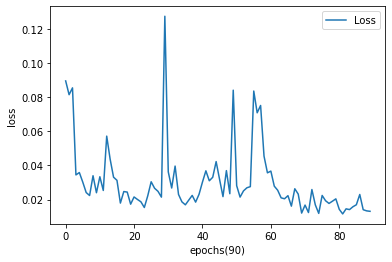

In [ ]:
plt.plot(losses)
plt.xlabel(f"epochs({num_epochs})")
plt.ylabel(f"loss")
_ = plt.legend(['Loss'])

In [ ]:
mlp.eval()
with torch.no_grad():
  #lr_probs = cnn(X_train.view(-1,1,1,41)).detach().squeeze()
  lr_probs = mlp(X_test).detach().squeeze()
probs = torch.max(lr_probs, dim=1)
idxs, scores = probs.indices, probs.values
probs = [scores[i].item() if idxs[i]==1 else 1-scores[i].item() for i in range(len(idxs))]
preds = torch.argmax(lr_probs, dim=1).cpu()
lr_probs = torch.max(lr_probs, dim=1).values
probs = np.array(probs)

In [ ]:
suspicious = probs[(probs>0.4) & (probs<0.5)].shape[0]

In [ ]:
print(f'{suspicious} packets are suspicious')

206 packets are suspicious


In [ ]:
cm = confusion_matrix(y_test, preds)
tn=cm[1][1] #tn
fn=cm[0][1] #fn
fp=cm[1][0] #fp
tp=cm[0][0] #tp
acc= (tp+tn)/(tp+tn+fn+fp)
epsilon = 1e-7 # is used so that to avoid divide by zero error
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon)
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
print("Test accuracy is:"+str(format(acc,'.4f')))
print("Precision: "+str(format(precision,'.4f'))+"\nRecall: "+str(format(recall,'.4f')))

Test accuracy is:0.7926
Precision: 0.6820
Recall: 0.9718


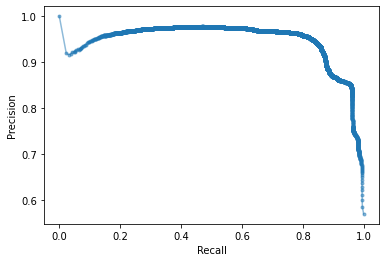

F1:	 78.295%
AUC:	 94.483%
Accuracy:79.263%


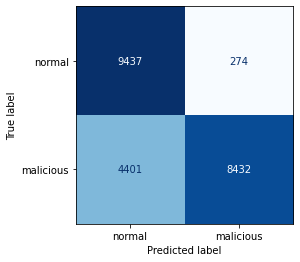

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, probs)
lr_f1, lr_auc = f1_score(y_test, preds), auc(lr_recall, lr_precision)
no_skill = len(y_test[y_test==0]) / len(y_test)
acc = accuracy_score(y_test, preds)
plt.plot(lr_recall, lr_precision, marker='.', alpha=0.5)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the plot
plt.show()
_ = plt.rc('legend', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['normal', 'malicious'])
disp.plot(cmap="Blues", colorbar = False)
print(f"F1:\t {lr_f1*100:.3f}%")
print(f"AUC:\t {lr_auc*100:.3f}%")
print(f"Accuracy:{acc*100:.3f}%")

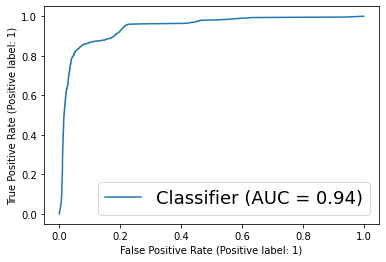

In [ ]:
_ = RocCurveDisplay.from_predictions(y_test,probs)

In [ ]:
wandb.finish()

In [ ]:
torch.save(mlp.state_dict(), 'mlp.pt')